In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['ieee-fraud-detection', 'feature-selection-ieee']


In [2]:
null_feat_imps=pd.read_csv('../input/feature-selection-ieee/Null_imp.csv')
actual_feat_imp=pd.read_csv('../input/feature-selection-ieee/Actual_imp.csv')

In [3]:
train_identity=pd.read_csv('../input/ieee-fraud-detection/train_identity.csv')
# test_identity=pd.read_csv('../input/test_identity.csv')
train_transaction=pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv')
# test_transaction=pd.read_csv('../input/test_transaction.csv')

In [4]:
train=pd.merge(train_transaction,train_identity,how='left',on='TransactionID')
# test=pd.merge(test_transaction,test_identity,how='left',on='TransactionID')

In [5]:
del train_identity,train_transaction

In [6]:
target=train['isFraud']
train=train.drop(['isFraud','TransactionID'],axis=1)
# test=test.drop('TransactionID',axis=1)

In [7]:
from sklearn.model_selection import train_test_split

train,val,target,val_y=train_test_split(train,target,test_size=0.5,random_state=5,stratify=target)

In [8]:
del val,val_y

In [9]:
train=train.fillna(-999)
# test=test.fillna(-999)

In [10]:
from sklearn.preprocessing import LabelEncoder

cat_cols=[col for col in train.columns if train[col].dtype=='object']
for col in cat_cols:
    le=LabelEncoder()
    le.fit(list(train[col].values))
    train[col]=le.transform(list(train[col].values))
#     test[col]=le.transform(list(test[col].values))

In [11]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.06 µs


In [12]:
train=reduce_mem_usage(train)
# test=reduce_mem_usage(test)

Memory usage of dataframe is 975.43 MB
Memory usage after optimization is: 262.72 MB
Decreased by 73.1%


In [13]:
correlation_scores=[]

for feature in train.columns:
    null_imp=null_feat_imps[null_feat_imps['features']==feature]['importances'].values
    actual_imp=actual_feat_imp[actual_feat_imp['features']==feature]['importances'].values
    corr_score=100*(null_imp < actual_imp).sum()/null_imp.size
    correlation_scores.append((feature,corr_score))

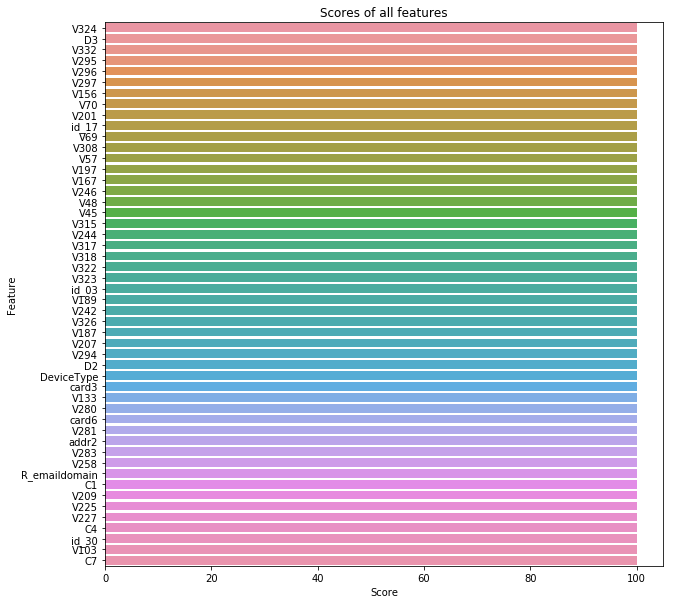

In [14]:
correlation_df=pd.DataFrame(correlation_scores,columns=['Feature','Score']).sort_values('Score',ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,10))
sns.barplot(x='Score',y='Feature',data=correlation_df.iloc[:50,:])
plt.title('Scores of all features')
plt.show()

In [15]:
feature_distdf=[]

for feature in actual_feat_imp['features'].values:
    dist=np.abs(actual_feat_imp[actual_feat_imp['features']==feature]['importances'].values - np.mean(null_feat_imps[null_feat_imps['features']==feature]['importances'].values))
    feature_distdf.append((feature,dist[0]))

In [16]:
feature_df=pd.DataFrame(feature_distdf,columns=['Feature','Distance_from_Mean']).sort_values('Distance_from_Mean',ascending=False).reset_index(drop=True)

Text(0.5, 1.0, 'Distance of Actual Importance from Mean of Null Importances')

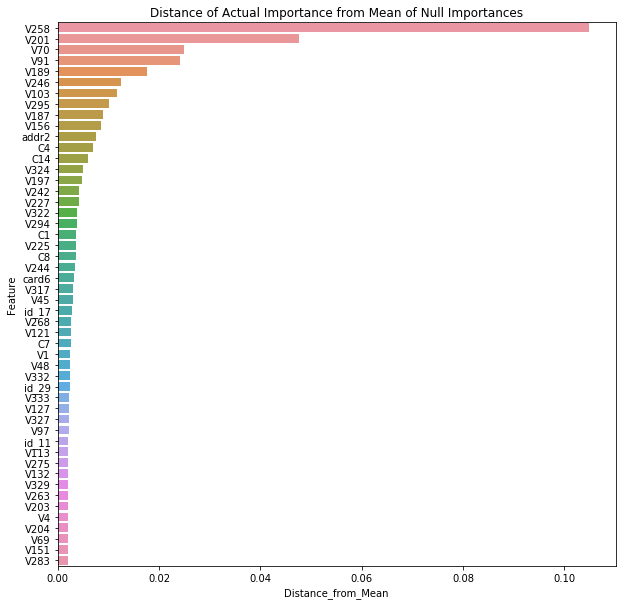

In [17]:
plt.figure(figsize=(10,10))
sns.barplot(x='Distance_from_Mean',y='Feature',data=feature_df[:50])
plt.title('Distance of Actual Importance from Mean of Null Importances')

In [18]:
def get_selection_score(data=train,target=target):
    xgb_params=dict(
                    verbosity=0,
                    tree_method='gpu_hist',
                    colsample_bytree=0.8,
               subsample=0.8,
               learning_rate=0.05,
               max_depth=5,
                   objective='binary:logistic',
                   metric='auc')
    
    train_d=xgb.DMatrix(data,label=target)
    result=xgb.cv(xgb_params,train_d,num_boost_round=1000,nfold=3,stratified=True,shuffle=True,early_stopping_rounds=50,verbose_eval=0,
                 seed=5,metrics=('auc'))
    
    
    return (list(result['test-auc-mean'].values)[-1], list(result['test-auc-std'].values)[-1])

In [19]:
# for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:  
#     print('Result for threshold ',threshold)
#     worthy_features=[feature for feature in correlation_df['Feature'].values if correlation_df.loc[correlation_df['Feature']==feature,'Score'].values>=threshold]
#     score=get_selection_score(train[worthy_features],target)
#     print('Test AUC Mean :',score[0])
#     print('Test AUC Std:',score[1])
#     del score

In [20]:
for threshold in [0,0.0001,0.0003,0.0005,0.0008,0.001,0.003,0.005,0.008,0.01,0.015,0.025,0.05]:  
    print('Result for threshold ',threshold)
    worthy_features=[feature for feature in feature_df['Feature'].values if feature_df.loc[feature_df['Feature']==feature,'Distance_from_Mean'].values>=threshold]
    score=get_selection_score(train[worthy_features],target)
    print('Test AUC Mean :',score[0])
    print('Test AUC Std:',score[1])
    del score

Result for threshold  0


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.9381013333333333
Test AUC Std: 0.0026992169646440495
Result for threshold  0.0001


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.937983
Test AUC Std: 0.002290819504020357
Result for threshold  0.0003


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.937017
Test AUC Std: 0.00285112410579873
Result for threshold  0.0005


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.9345666666666667
Test AUC Std: 0.002453982386969298
Result for threshold  0.0008


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.934418
Test AUC Std: 0.0030615134601478973
Result for threshold  0.001


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.9258383333333334
Test AUC Std: 0.002686196360821171
Result for threshold  0.003


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.8680806666666667
Test AUC Std: 0.0032817197050056435
Result for threshold  0.005


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.8426533333333334
Test AUC Std: 0.0015724185900141943
Result for threshold  0.008


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.806759
Test AUC Std: 0.002569768212634517
Result for threshold  0.01


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.7988106666666667
Test AUC Std: 0.002899582307084187
Result for threshold  0.015


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.753518
Test AUC Std: 0.003900927411099399
Result for threshold  0.025


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.7448446666666667
Test AUC Std: 0.002638233036628027
Result for threshold  0.05


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Test AUC Mean : 0.6659926666666667
Test AUC Std: 0.0037968170295071733
